In [1]:
# ! pip install -r requirements.txt

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.diagnostic as smd
import pandas as pd
digit=3

In [ ]:
class DataPrep():
    def __init__(self, path):
        self.path= path

    def get_data(self, digit=3):
        with h5py.File(self.path, 'r') as hf:
            train_images = np.array(hf["train"]["data"]) 
            train_labels = np.array(hf["train"]["target"])

        
        digit_data = train_images[train_labels == digit]

        # Flatten images (16x16) into vectors (256-dimensional)
        x = digit_data.reshape(digit_data.shape[0], -1)
        return x

    def center_data(self, x):
        # Normalize the data (mean centering)
        scaler = StandardScaler(with_std=False)
        x_centered = scaler.fit_transform(x)
        return x_centered


file_path = "usps.h5"
prep_obj= DataPrep(file_path)
x= prep_obj.get_data(digit= digit)
x_centered= prep_obj.center_data(x)
x_centered.shape

(658, 256)

## RQ 1

In [4]:
class Q1():
    def __init__(self, x_centered):
        self.x= x_centered

    def svd(self,):
        self.U, self.S, self.Vt = np.linalg.svd(self.x, full_matrices=False)

        return self.U, self.S, self.Vt

    def plot(self, x, y=None, title:str=None, xlabel:str=None, ylabel:str=None):
        # Plot singular values in descending order
        plt.figure(figsize=(6, 5))
        if x is not None and y is not None:
            plt.plot(x, y, marker='o', linestyle='-', color='orange')
        else:
            plt.plot(x, marker='o', linestyle='-', color='orange')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid()
        plt.show()

    def reconstruct_data(self, U, S, Vt, q=5):
        U_q = U[:, :q]
        S_q = np.diag(S[:q])
        Vt_q = Vt[:q, :]
        X_q = U_q @ S_q @ Vt_q
        return X_q, U_q, S_q, Vt_q
    
    def get_rank(self, matrix):
        rank= np.linalg.matrix_rank(matrix)
        return rank

    def mse_for_first_q(self, U, S, Vt, q=20):
        mse_values = []
        q_values = range(1, q)
        n= self.x.shape[0]
        d= self.x.shape[1]
        for i in q_values:
            x_q, _ ,_ ,_ = self.reconstruct_data(U, S, Vt, q=i)
            mse = np.mean((self.x - x_q) ** 2)
            mse_values.append(mse)
           
            # self.plot(x= q_values, y= mse_values, title=None)
            # print(f"Shape of x_q: {x_q.shape}")
            # mse_values= mse_values/(n*d)
        # np.sum((self.x - x_q) ** 2) / (n * d)
        return mse_values
    
    def explained_variance(self, S,):
        # s_q= S[:q]
        self.expvar= np.cumsum(np.square(S))
        return self.expvar
    
    def appropriate_value(self, S):
        q= len(self.expvar)
        sum_squares= np.sum(np.square(S[:q]))
        return np.argmax((self.expvar/ sum_squares)>=0.95)+1

q1= Q1(x_centered)
U, S, Vt= q1.svd()

## a

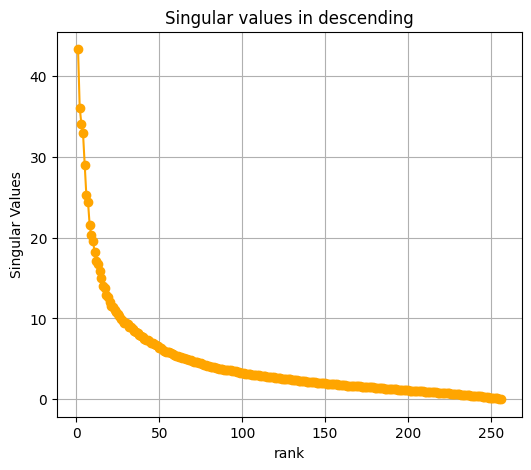

In [5]:
rank= q1.get_rank(x_centered)

q1.plot(x= range(1, rank+2), y=S[:rank+1], title="Singular values in descending", xlabel= "rank", ylabel="Singular Values")

## b

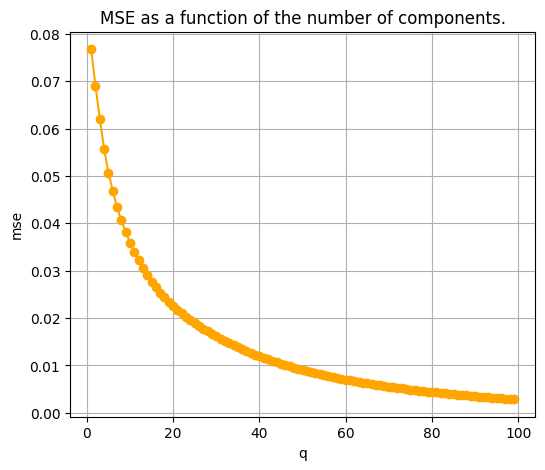

In [6]:
mse= q1.mse_for_first_q(U, S, Vt, q=100)
q1.plot(x=range(1,100), y=mse, xlabel= "q", ylabel="mse", title=f"MSE as a function of the number of components.")

## c

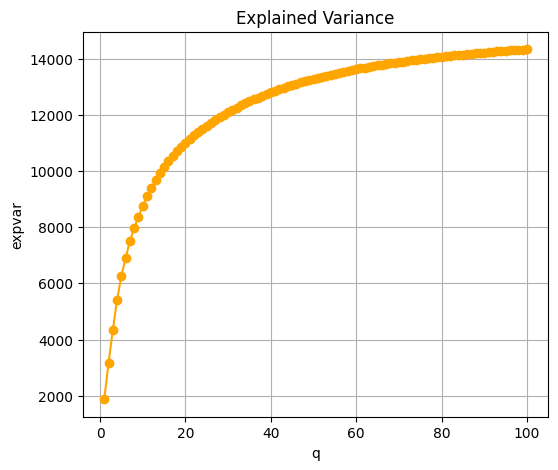

In [7]:
expvar= q1.explained_variance(S[:100])
expvar
q1.plot(y= expvar, x= range(1, len(expvar)+1), xlabel='q', ylabel="expvar", title="Explained Variance")

In [9]:
X_q, U_q, S_q, Vt_q = q1.reconstruct_data(U, S, Vt, q=5)
print(X_q.shape, U_q.shape, S_q.shape , Vt_q.shape)

(658, 256) (658, 5) (5, 5) (5, 256)


## Fit Distributions

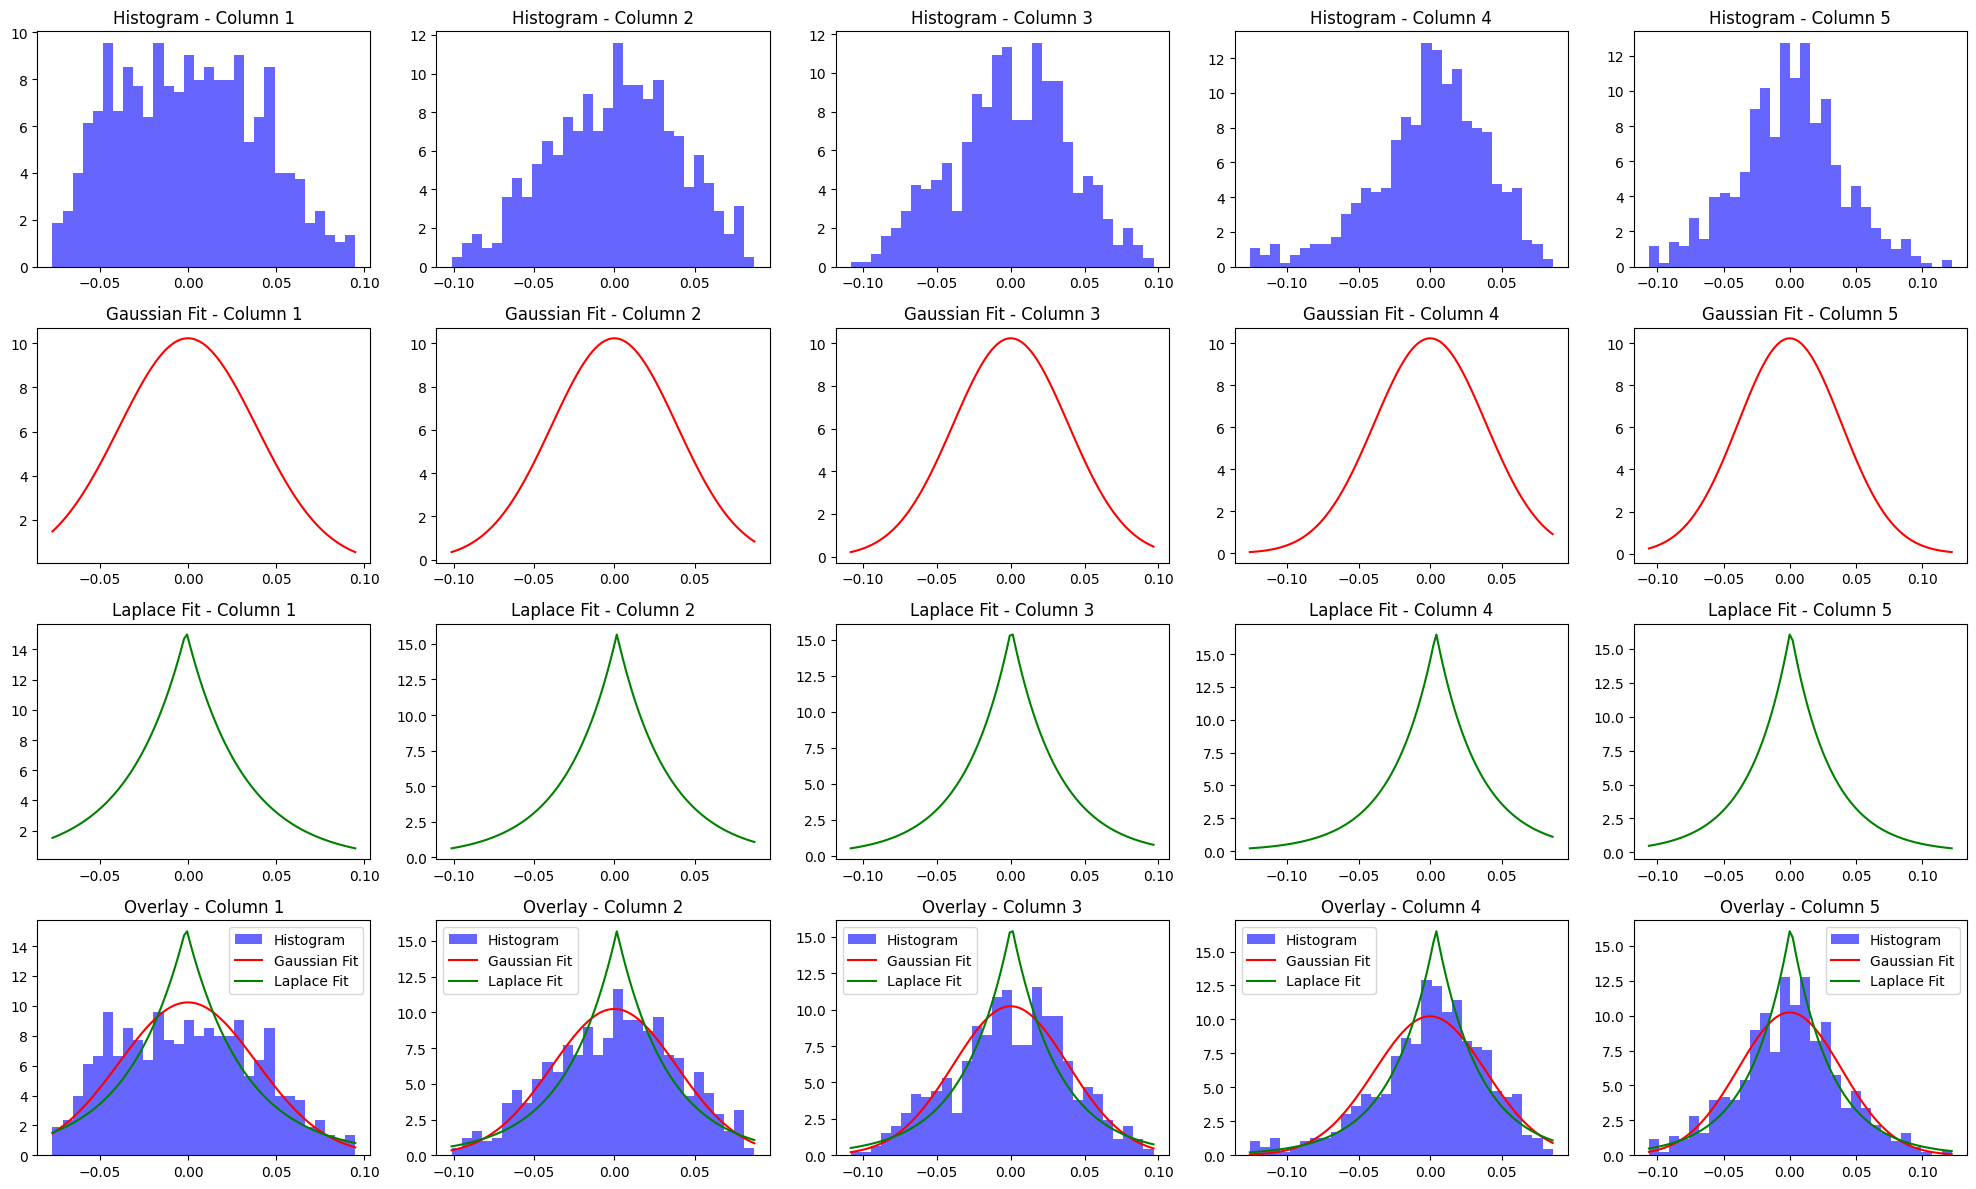

In [10]:
q = 5
fig, axes = plt.subplots(4, q, figsize=(20, 12))

for i in range(0, q):
    data = U_q[:, i]
    
    # Fit distributions
    mu_gauss, sigma_gauss = stats.norm.fit(data)  
    mu_laplace, b_laplace = stats.laplace.fit(data)  
    x_vals = np.linspace(min(data), max(data), 100)
    pdf_gauss = stats.norm.pdf(x_vals, mu_gauss, sigma_gauss)
    pdf_laplace = stats.laplace.pdf(x_vals, mu_laplace, b_laplace)

    # Row 1: Histogram
    axes[0, i].hist(data, bins=30, density=True, color='blue', alpha=0.6)
    axes[0, i].set_title(f"Histogram - Column {i+1}")

    # Row 2: Gaussian Fit
    axes[1, i].plot(x_vals, pdf_gauss, 'r-')
    axes[1, i].set_title(f"Gaussian Fit - Column {i+1}")

    # Row 3: Laplace Fit
    axes[2, i].plot(x_vals, pdf_laplace, 'g-')
    axes[2, i].set_title(f"Laplace Fit - Column {i+1}")

    # Row 4: Overlay
    axes[3, i].hist(data, bins=30, density=True, color='blue', alpha=0.6, label="Histogram")
    axes[3, i].plot(x_vals, pdf_gauss, 'r-', label="Gaussian Fit")
    axes[3, i].plot(x_vals, pdf_laplace, 'g-', label="Laplace Fit")
    axes[3, i].set_title(f"Overlay - Column {i+1}")
    axes[3, i].legend()

plt.tight_layout()
plt.show()

In [11]:
ks_best_fit = []
gaussian_params = []
laplace_params = []
ad_best_fit = []
for i in range(0, 5):

    data = U_q[:, i]

    # Fit Gaussian and Laplace distributions
    mu_gauss, sigma_gauss = stats.norm.fit(data)  # Gaussian parameters
    mu_laplace, b_laplace = stats.laplace.fit(data)  # Laplace parameters
    
    # Perform Kolmogorov-Smirnov test
    ks_gauss_stat, ks_gauss_p = stats.kstest(data, 'norm', args=(mu_gauss, sigma_gauss))
    ks_laplace_stat, ks_laplace_p = stats.kstest(data, 'laplace', args=(mu_laplace, b_laplace))

    ad_gauss_stat, _ = smd.normal_ad(data)

    # Perform Anderson-Darling test for Laplace (using SciPy's empirical CDF approach)
    sorted_data = np.sort(data)
    n = len(data)
    cdf_laplace = stats.laplace.cdf(sorted_data, loc=mu_laplace, scale=b_laplace)
    ad_laplace_stat = -n - np.sum((2 * np.arange(1, n + 1) - 1) / n * (np.log(cdf_laplace) + np.log(1 - cdf_laplace[::-1])))

    # Determine best fit based on lower test statistic for KS and AD
    ks_best_fit.append("Gaussian" if ks_gauss_stat < ks_laplace_stat else "Laplace")
    ad_best_fit.append("Gaussian" if ad_gauss_stat < ad_laplace_stat else "Laplace")

    # Store distribution parameters
    gaussian_params.append(f"Mean: {mu_gauss:.4f}, Variance: {sigma_gauss**2:.4f}")
    laplace_params.append(f"Loc: {mu_laplace:.4f}, Scale: {b_laplace:.4f}")
    
df = pd.DataFrame({
    "Q": [f"{i+1}" for i in range(q)],
    "KS Best Fit": ks_best_fit,
    "AD Best Fit": ad_best_fit,
    "Gaussian Parameters": gaussian_params,
    "Laplace Parameters": laplace_params
}, index= [f"{i+1}" for i in range(q)])
df

,Q,KS Best Fit,AD Best Fit,Gaussian Parameters,Laplace Parameters
1,1,Gaussian,Gaussian,"Mean: 0.0000, Variance: 0.0015","Loc: -0.0011, Scale: 0.0328"
2,2,Gaussian,Gaussian,"Mean: -0.0000, Variance: 0.0015","Loc: 0.0016, Scale: 0.0319"
3,3,Gaussian,Gaussian,"Mean: 0.0000, Variance: 0.0015","Loc: 0.0004, Scale: 0.0315"
4,4,Laplace,Laplace,"Mean: 0.0000, Variance: 0.0015","Loc: 0.0041, Scale: 0.0300"
5,5,Gaussian,Gaussian,"Mean: -0.0000, Variance: 0.0015","Loc: 0.0006, Scale: 0.0304"


## PCA

In [12]:
class PCA():
    def __init__(self, x_centered, q=5):
        self.x= x_centered
        _, _, _= self.svd()
        _, _, _, _= self.reconstruct_data(q)

    def reconstruct_data(self, q=5):
        self.U_q = self.U[:, :q]
        self.S_q = np.diag(self.S[:q])
        self.Vt_q = self.Vt[:q, :]
        self.X_q = U_q @ S_q @ Vt_q
        return self.X_q, self.U_q, self.S_q, self.Vt_q

    def svd(self,):
        self.U, self.S, self.Vt = np.linalg.svd(self.x, full_matrices=False)
        return self.U, self.S, self.Vt
    
    def generate_synthetic_data(self, q=5):
        zero_array = np.zeros_like(self.U_q)
        n_samples = self.X_q.shape[0]
        mu_gauss, sigma_gauss = stats.norm.fit(self.U_q)

        U_sampled_q = stats.norm.rvs(loc=mu_gauss, scale=sigma_gauss, size= zero_array.shape)
        X_hat_q = U_sampled_q @ S_q @ Vt_q
        
        mean_vector = np.mean(x_centered, axis=0)
        mse = np.mean((x_centered - X_hat_q) ** 2)
        sigma = (mse)
        W = np.random.normal(loc=0, scale=sigma, size=X_hat_q.shape)

        x_new_pca = X_hat_q + mean_vector  + W
       
        return x_new_pca


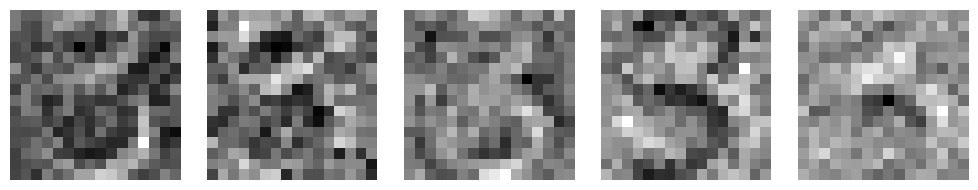

In [13]:

pca= PCA(x_centered)
U, S, Vt= pca.svd()
X_q, U_q, S_q, Vt_q= pca.reconstruct_data()
x_new_pca= pca.generate_synthetic_data()
x_new_pca.shape

random_indices = np.random.choice(x_new_pca.shape[0], size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))

for i, idx in enumerate(random_indices):
    img_2d = x_new_pca[idx].reshape(16, 16)
    
    # Display the image
    axes[i].imshow(img_2d, cmap='gray')
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

## Mean image - Real Vs Synthetic

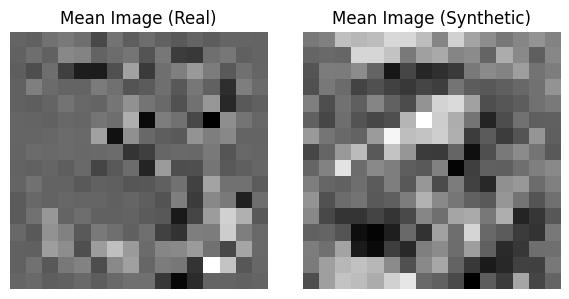

In [14]:
# Compute mean image for real and synthetic datasets
mean_real = np.mean(X_q, axis=0).reshape(16, 16)
mean_synthetic = np.mean(x_new_pca, axis=0).reshape(16, 16)

# Display side-by-side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(mean_real, cmap='gray')
axes[0].set_title("Mean Image (Real)")
axes[0].axis('off')

axes[1].imshow(mean_synthetic, cmap='gray')
axes[1].set_title("Mean Image (Synthetic)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

## For Different values of q

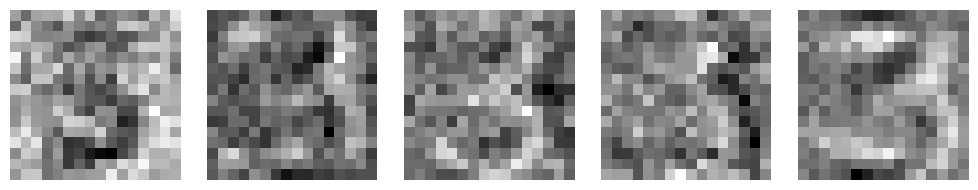

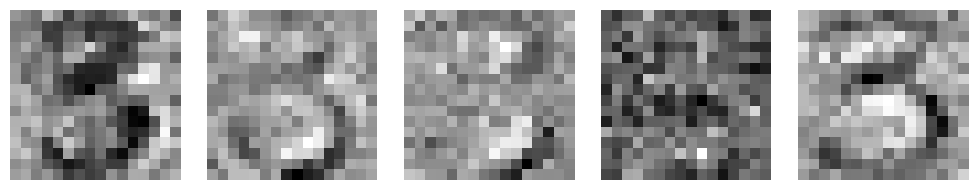

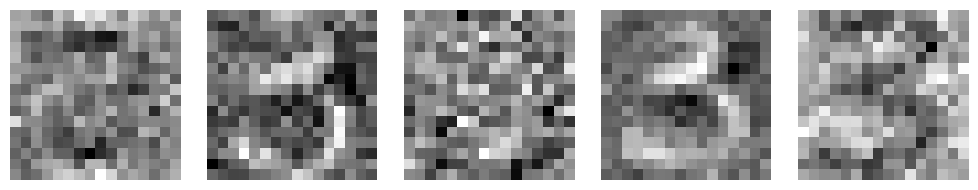

In [ ]:
# Try different values of q
q_values = [5, 7, 9]
n_samples = X_q.shape[0]
d = X_q.shape[1]
#fig, axes = plt.subplots(len(q_values), 5, figsize=(10, 6))

for row, q in enumerate(q_values):
    
    pca= PCA(x_centered)
    U, S, Vt= pca.svd()
    X_q, U_q, S_q, Vt_q= pca.reconstruct_data()
    x_new_pca= pca.generate_synthetic_data()

    random_indices = np.random.choice(x_new_pca.shape[0], size=5, replace=False)

    fig, axes = plt.subplots(1, 5, figsize=(10, 2))

    for i, idx in enumerate(random_indices):
        img_2d = x_new_pca[idx].reshape(16, 16)
        
        # Display the image
        axes[i].imshow(img_2d, cmap='gray')
        axes[i].axis('off') 
        axes[i].set_ylabel("i")

    plt.tight_layout()
    plt.show()

In [16]:
# Compute the mean-centered data matrix
x_mean = np.mean(X_q, axis=0)
x_centered = X_q - x_mean

# Compute the empirical covariance matrix
cov_X = (x_centered.T @ x_centered) / (X_q.shape[0] - 1)

print(f"Shape of Covariance Matrix: {cov_X.shape}")
# print("Sample Covariance Matrix:\n", cov_X)

Shape of Covariance Matrix: (256, 256)


In [17]:
# Dimensions of the covariance matrix
d = X_q.shape[1]  # Number of features]
print(f"Covariance matrix dimensions: {d} × {d}")

Covariance matrix dimensions: 256 × 256


In [18]:
# Compute the mean-centered synthetic data matrix
X_hat_mean = np.mean(x_new_pca, axis=0)
X_hat_centered = x_new_pca - X_hat_mean

# Compute the empirical covariance matrix of synthetic data
cov_X_hat = (X_hat_centered.T @ X_hat_centered) / (x_new_pca.shape[0] - 1)

print(f"Shape of Covariance Matrix for Synthetic Data: {cov_X_hat.shape}")
# print("Sample Covariance Matrix of Synthetic Data:\n", cov_X_hat)

Shape of Covariance Matrix for Synthetic Data: (256, 256)


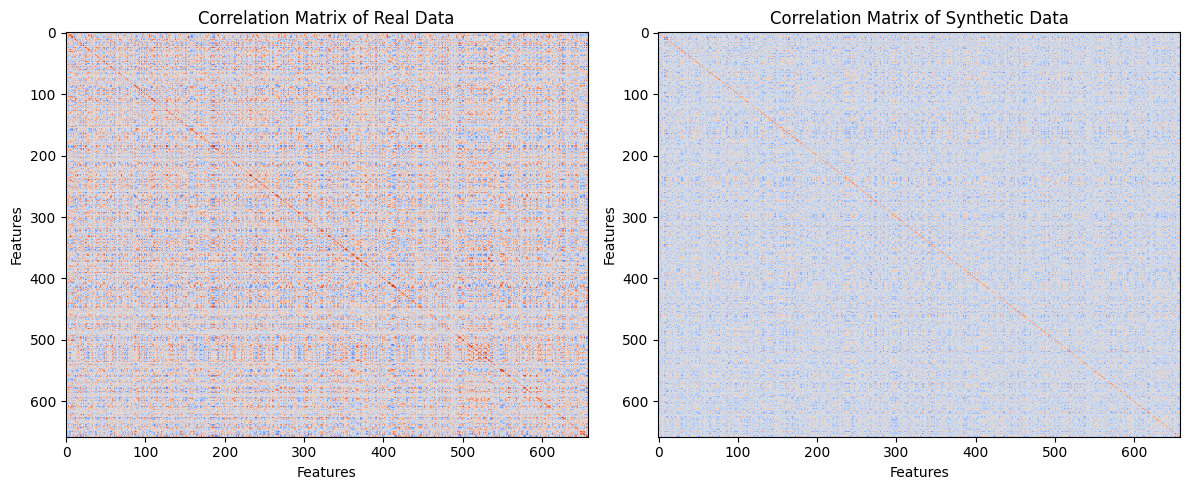

In [19]:
# Compute correlation matrices for real and synthetic data
C_real = np.corrcoef(x_centered, rowvar=True)  
C_synthetic = np.corrcoef(x_new_pca, rowvar=True)

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(C_real, cmap='coolwarm', aspect='auto')
axes[0].set_title("Correlation Matrix of Real Data")
axes[0].set_xlabel("Features")
axes[0].set_ylabel("Features")

axes[1].imshow(C_synthetic, cmap='coolwarm', aspect='auto')
axes[1].set_title("Correlation Matrix of Synthetic Data")
axes[1].set_xlabel("Features")
axes[1].set_ylabel("Features")

plt.tight_layout()
plt.show()

In [ ]:
n, k = C_real.shape
pca_L2_diff = np.mean((C_real - C_synthetic) ** 2)
# np.linalg.norm(C_real, C_synthetic)
print(f"L2 Difference: {pca_L2_diff}")

L2 Difference: 0.29596653287101005


# Probabilistic Principal Component Analysis (PPCA)

In [21]:
class PPCA():
    def __init__(self, x_centered, q=5):
        self.x= x_centered
        _, _, _= self.svd()
        _, _, _, _= self.reconstruct_data(q)

    def reconstruct_data(self, q=5):
        self.U_q = self.U[:, :q]
        self.S_q = np.diag(self.S[:q])
        self.Vt_q = self.Vt[:q, :]
        self.X_q = U_q @ S_q @ Vt_q
        return self.X_q, self.U_q, self.S_q, self.Vt_q

    def svd(self,):
        self.U, self.S, self.Vt = np.linalg.svd(self.x, full_matrices=False)
        return self.U, self.S, self.Vt
    
    def generate_synthetic_data(self, q=5):
        n_samples = self.X_q.shape[0]
        z_new = np.random.randn(n_samples, q)

        x_mean = np.mean(self.X_q, axis=0)

        d = self.X_q.shape[1]
        sigma_sq = (1 / (d - q)) * np.sum((self.S[q:]**2))
        sigma = np.sqrt(sigma_sq)

        epsilon = np.random.normal(loc=0, scale=sigma, size=(n_samples, d))

        x_new = z_new @ Vt_q + x_mean + epsilon
        return x_new


In [22]:
U, S, Vt= q1.svd()
X_q, U_q, S_q, Vt_q = q1.reconstruct_data(U, S, Vt, q=5)
ppca= PPCA(x_centered)
U, S, Vt= ppca.svd()
X_q, U_q, S_q, Vt_q= ppca.reconstruct_data()
x_new_ppca= ppca.generate_synthetic_data()
x_new_ppca.shape

(658, 256)

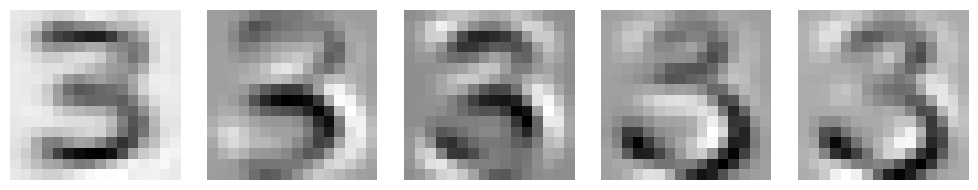

In [23]:
# Plot images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

for i, idx in enumerate(np.random.choice(x_new_ppca.shape[0], size=5, replace=False)):
    img_2d = x_new_ppca[idx].reshape(16, 16)
    axes[i].imshow(img_2d, cmap='gray')
    axes[i].axis('off') 

plt.tight_layout()
plt.show()

## Mean image - Real vs Synthetic

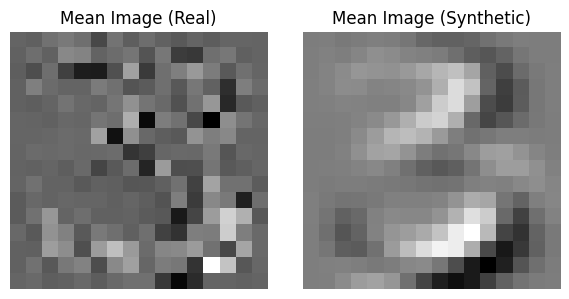

In [24]:
# Compute mean image for real and synthetic datasets
mean_real = np.mean(X_q, axis=0).reshape(16, 16)
mean_synthetic = np.mean(x_new_ppca, axis=0).reshape(16, 16)

# Display side-by-side
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(mean_real, cmap='gray')
axes[0].set_title("Mean Image (Real)")
axes[0].axis('off')

axes[1].imshow(mean_synthetic, cmap='gray')
axes[1].set_title("Mean Image (Synthetic)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

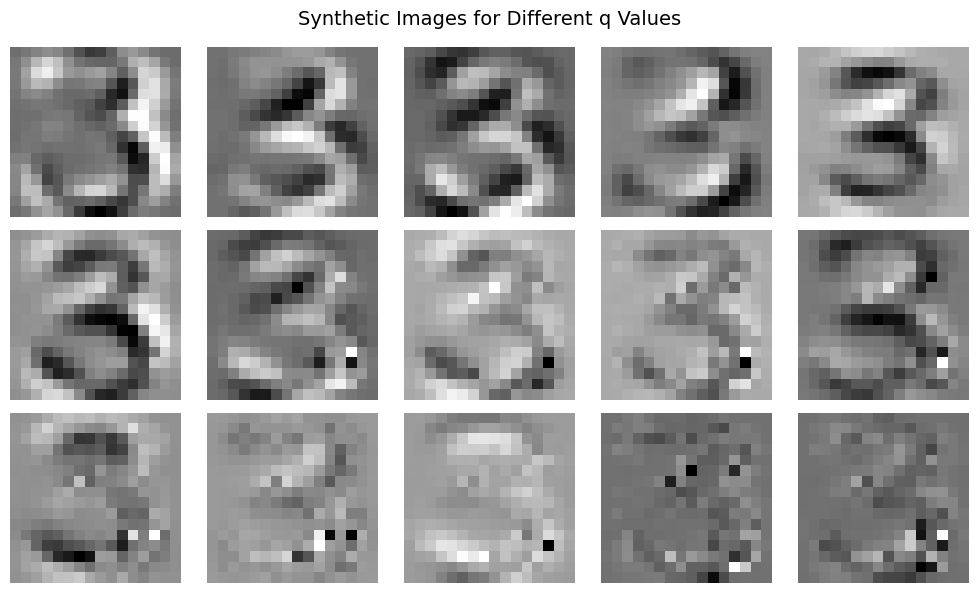

In [25]:
# Try different values of q
q_values = [5, 7, 9]
n_samples = X_q.shape[0]
d = X_q.shape[1]
fig, axes = plt.subplots(len(q_values), 5, figsize=(10, 6))

for row, q in enumerate(q_values):
    # Generate new synthetic data for each q
    z_new = np.random.randn(n_samples, q)
    V_q = Vt[:q, :].T

    
     
    sigma_sq = (1 / (d - q)) * np.sum(S[q:]**2)  # Sum of discarded singular values
    sigma = np.sqrt(sigma_sq)  # Standard deviation
    x_new_q = z_new @ V_q.T + x_mean + np.random.normal(loc=0, scale=sigma, size=(n_samples, d))

    # Display 5 random images for each q
    for i in range(5):
        img_2d = x_new_q[i].reshape(16, 16)
        axes[row, i].imshow(img_2d, cmap='gray')
        axes[row, i].axis('off')

    axes[row, 0].set_ylabel(f"q = {q}", fontsize=12)

plt.suptitle("Synthetic Images for Different q Values", fontsize=14)
plt.tight_layout()
plt.show()

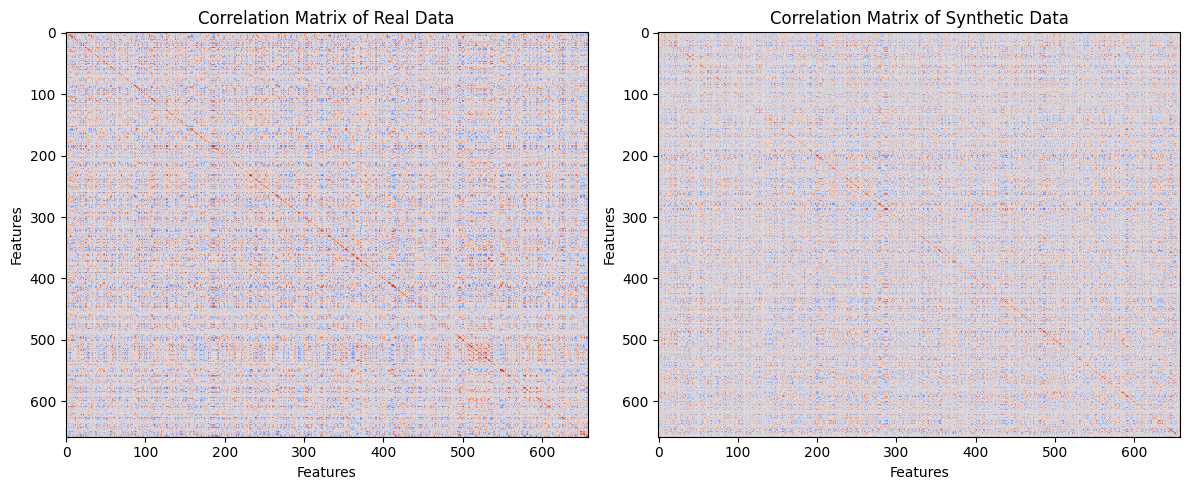

In [26]:
# Compute correlation matrices for real and synthetic data
C_real = np.corrcoef(x_centered, rowvar= True)  
C_synthetic = np.corrcoef(x_new_ppca, rowvar= True)

# Plot heatmaps of correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(C_real, cmap='coolwarm', aspect='auto')
axes[0].set_title("Correlation Matrix of Real Data")
axes[0].set_xlabel("Features")
axes[0].set_ylabel("Features")

axes[1].imshow(C_synthetic, cmap='coolwarm', aspect='auto')
axes[1].set_title("Correlation Matrix of Synthetic Data")
axes[1].set_xlabel("Features")
axes[1].set_ylabel("Features")

plt.tight_layout()
plt.show()

In [27]:
# Compute L2 difference between correlation matrices
n, k = C_real.shape
ppca_L2_diff = np.mean((C_real - C_synthetic) ** 2)

print(f"L2 Difference:  {ppca_L2_diff}")


L2 Difference:  0.426026756503084


In [28]:
print(f"PCA L2 diff= {pca_L2_diff}, \nPPCA L2 diff= {ppca_L2_diff}")

PCA L2 diff= 0.29596653287101005, 
PPCA L2 diff= 0.426026756503084
